In [15]:

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
from matplotlib import colormaps #type: ignore

task = 'cola'
epochs = 3

cmp = 'viridis'
sv = False
dpi = 300
transparent = False

print(os.getcwd())
pth = f'c:/Ebooks/code/Research/Tasks/stitch/{task}'
pth = os.path.join(os.getcwd(), pth)
if sv:
    Path(pth).mkdir(parents=True, exist_ok=True)
print(pth)

c:\Ebooks\code\BertFt
c:/Ebooks/code/Research/Tasks/stitch/cola


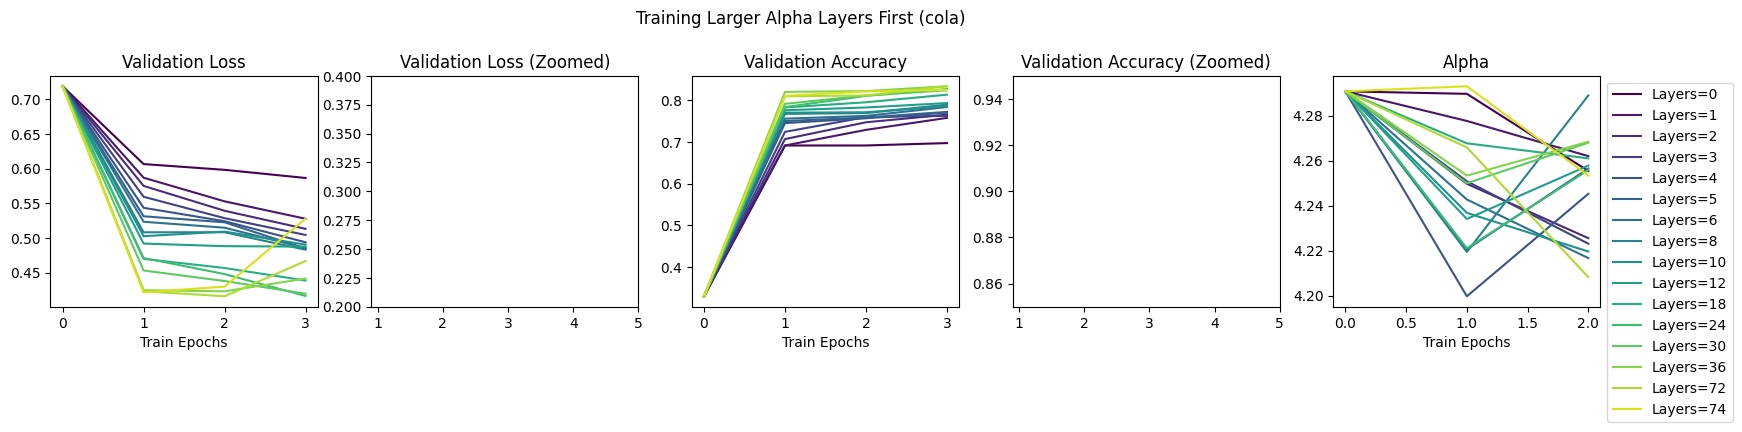

In [16]:
plt.figure(figsize=(20, 3))
first_val_loss = []
first_val_acc = []

layers = [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 18, 24, 30, 36, 72, 74]
cmap = colormaps[cmp]
# cmap =  get_cmap(cmp, len(layers)))

for l_idx, layer in enumerate(layers):
    base_path = f"task_{task}/lay_norm_False/alpha_asc_False/layers_{layer}/lr2e-5_epoch3_bs32/"
    
    path = os.path.join(base_path, 'baseline.npy')
    
    alpha_vals = []
    for epoch in range (0, epochs, 1):
        csv_path = os.path.join(base_path, 'stats', f'epoch_{epoch}.csv')
        df = pd.read_csv(csv_path)
        alpha_vals.append(np.mean(df['alpha'][2:]))

    baseline = np.load(path, allow_pickle=True).item()
    first_val_loss.append(baseline['val_loss_base'])
    first_val_acc.append(baseline['val_acc_base'])
    
    plt.subplot(1, 5, 1)
    plt.plot(baseline['val_loss_base'], label=f'Layers={layer}', c=cmap(l_idx/len(layers)))
    plt.xlabel('Train Epochs')
    plt.title('Validation Loss')
    
    plt.subplot(1, 5, 2)
    plt.plot(baseline['val_loss_base'][:], label = f'Layers={layer}', c=cmap(l_idx/len(layers)))
    plt.xlim([0.9, 5])
    plt.ylim([0.2, 0.4])
    plt.title('Validation Loss (Zoomed)')
    
    plt.subplot(1, 5, 3)
    plt.plot(baseline['val_acc_base'], label=f'Layers={layer}', c=cmap(l_idx/len(layers)))
    plt.xlabel('Train Epochs')
    plt.title('Validation Accuracy')
    
    plt.subplot(1, 5, 4)
    plt.plot(baseline['val_acc_base'][:], label=f'Layers={layer}', c=cmap(l_idx/len(layers)))
    plt.xlim([0.9, 5])
    plt.ylim([0.85, 0.95])
    plt.title('Validation Accuracy (Zoomed)')
    
    plt.subplot(1, 5, 5)
    plt.plot(alpha_vals[:], label=f'Layers={layer}', c=cmap(l_idx/len(layers)))
    plt.xlabel('Train Epochs')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title('Alpha')
    
plt.suptitle(f'Training Larger Alpha Layers First ({task})', fontsize=12, y=1.1)
if sv:
    plt.savefig(f'{pth}/large_alph.png', transparent=transparent, dpi=dpi)

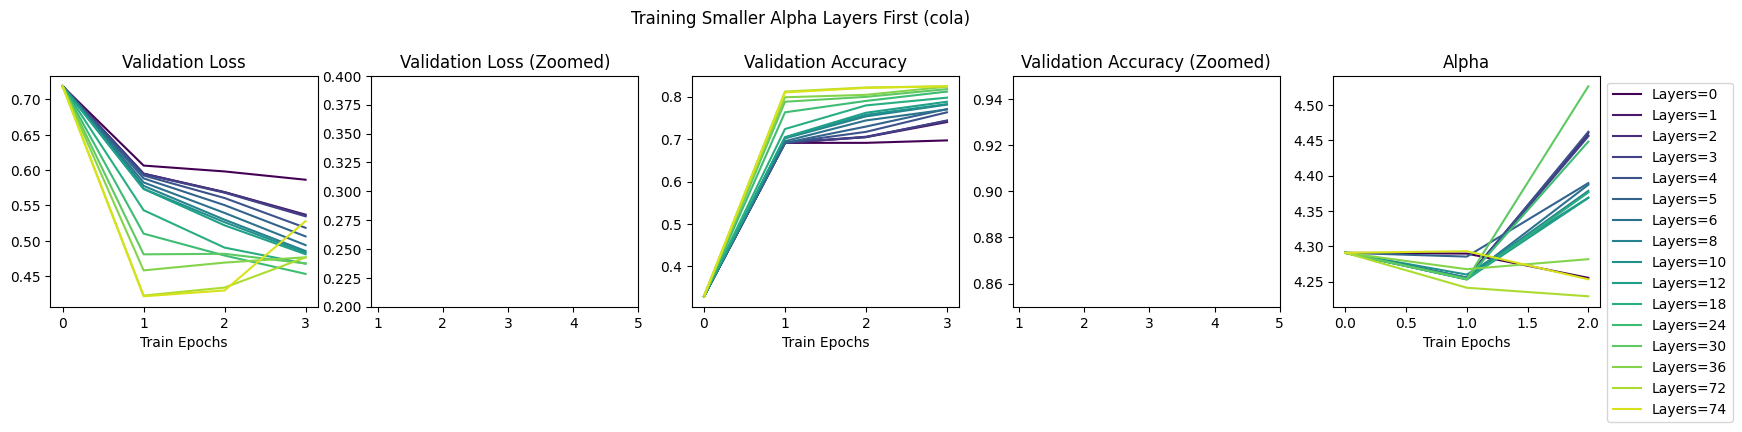

In [17]:
plt.figure(figsize=(20, 3))
first_val_loss = []
first_val_acc = []

layers = [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 18, 24, 30, 36, 72, 74]
cmap =  colormaps[cmp]

for l_idx, layer in enumerate(layers):
    base_path = f"task_{task}/lay_norm_False/alpha_asc_True/layers_{layer}/lr2e-5_epoch3_bs32/"
    
    path = os.path.join(base_path, 'baseline.npy')
    
    alpha_vals = []
    for epoch in range (0, epochs, 1):
        csv_path = os.path.join(base_path, 'stats', f'epoch_{epoch}.csv')
        df = pd.read_csv(csv_path)
        alpha_vals.append(np.mean(df['alpha'][2:]))

    baseline = np.load(path, allow_pickle=True).item()
    first_val_loss.append(baseline['val_loss_base'])
    first_val_acc.append(baseline['val_acc_base'])
    
    plt.subplot(1, 5, 1)
    plt.plot(baseline['val_loss_base'], label=f'Layers={layer}', c=cmap(l_idx/len(layers)))
    plt.xlabel('Train Epochs')
    plt.title('Validation Loss')
    
    plt.subplot(1, 5, 2)
    plt.plot(baseline['val_loss_base'][:], label = f'Layers={layer}', c=cmap(l_idx/len(layers)))
    plt.xlim([0.9, 5])
    plt.ylim([0.2, 0.4])
    plt.title('Validation Loss (Zoomed)')
    
    plt.subplot(1, 5, 3)
    plt.plot(baseline['val_acc_base'], label=f'Layers={layer}', c=cmap(l_idx/len(layers)))
    plt.xlabel('Train Epochs')
    plt.title('Validation Accuracy')
    
    plt.subplot(1, 5, 4)
    plt.plot(baseline['val_acc_base'][:], label=f'Layers={layer}', c=cmap(l_idx/len(layers)))
    plt.xlim([0.9, 5])
    plt.ylim([0.85, 0.95])
    plt.title('Validation Accuracy (Zoomed)')
    
    plt.subplot(1, 5, 5)
    plt.plot(alpha_vals[:], label=f'Layers={layer}', c=cmap(l_idx/len(layers)))
    plt.xlabel('Train Epochs')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title('Alpha')
    
plt.suptitle(f'Training Smaller Alpha Layers First ({task})', fontsize=12, y=1.1)
if sv:
    plt.savefig(f'{pth}/small_alph.png', transparent=transparent, dpi=dpi)

In [18]:
dictionary = {
    "alpha_asc_False": {"first_val_loss": [], "first_val_acc": [], "alpha_vals": []},
    "alpha_asc_True": {"first_val_loss": [], "first_val_acc": [], "alpha_vals": []},
    "layer_asc_False": {"first_val_loss": [], "first_val_acc": [], "alpha_vals": []},
    "layer_asc_True": {"first_val_loss": [], "first_val_acc": [], "alpha_vals": []},
    "layer_asc_rand": {"first_val_loss": [], "first_val_acc": [], "alpha_vals": []},
}


for key in dictionary:
    layers = [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 18, 24, 30, 36, 72, 74]
    cmap = colormaps[cmp]

    for l_idx, layer in enumerate(layers):
        base_path = (
            f"task_{task}/lay_norm_False/{key}/layers_{layer}/lr2e-5_epoch3_bs32/"
        )
        path = os.path.join(base_path, "baseline.npy")

        alpha_vals = []
        for epoch in range(0, epochs, 1):
            stats_path = os.path.join(base_path, "stats", f"epoch_{epoch}.csv")
            df = pd.read_csv(stats_path)
            alpha_vals.append(np.mean(df["alpha"][2:]))

        baseline = np.load(path, allow_pickle=True).item()
        dictionary[key]["first_val_loss"].append(baseline["val_loss_base"])
        dictionary[key]["first_val_acc"].append(baseline["val_acc_base"])
        dictionary[key]["alpha_vals"].append(alpha_vals)

    dictionary[key]["first_val_loss"] = np.array(dictionary[key]["first_val_loss"])  # type: ignore
    dictionary[key]["first_val_acc"] = np.array(dictionary[key]["first_val_acc"])  # type: ignore
    dictionary[key]["alpha_vals"] = np.array(dictionary[key]["alpha_vals"])  # type: ignore

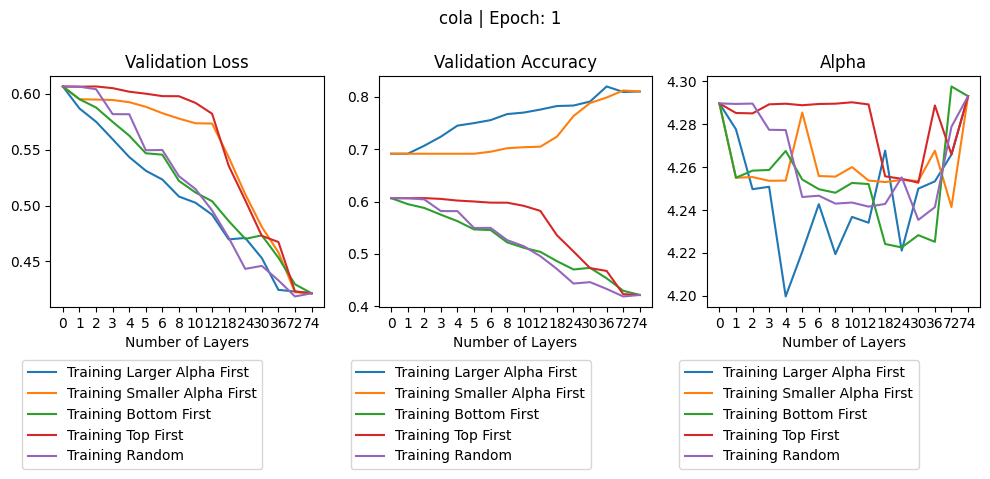

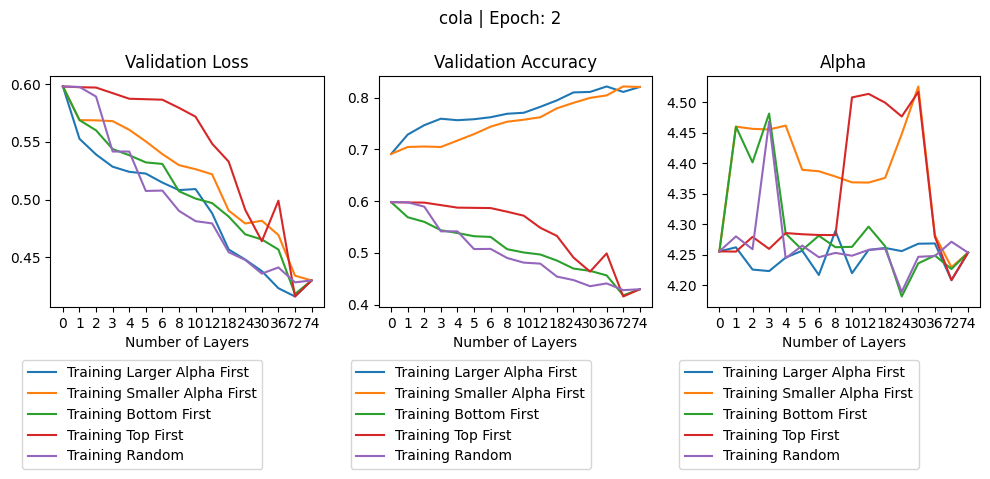

In [19]:
layer_cnt = len(layers)
marker_size = 2
show_marker = False
marker = 'o' if show_marker else None

for i in range(1, epochs, 1):
    plt.figure(figsize=(12, 3))

    plt.subplot(1, 3, 1)
    plt.plot(
        range(layer_cnt), dictionary["alpha_asc_False"]["first_val_loss"][:, i], # type: ignore
        markersize = marker_size,
        marker = marker,
        label="Training Larger Alpha First"
    )
    plt.plot(
        range(layer_cnt), dictionary["alpha_asc_True"]["first_val_loss"][:, i], # type: ignore
        markersize = marker_size,
        marker = marker,
        label="Training Smaller Alpha First"
    )
    plt.plot(
        range(layer_cnt), dictionary["layer_asc_False"]["first_val_loss"][:, i], # type: ignore
        markersize = marker_size,
        marker = marker,
        label="Training Bottom First"
    )
    plt.plot(
        range(layer_cnt), dictionary["layer_asc_True"]["first_val_loss"][:, i], # type: ignore
        markersize = marker_size,
        marker = marker,
        label="Training Top First"
    )
    plt.plot(
        range(layer_cnt), dictionary["layer_asc_rand"]["first_val_loss"][:, i], # type: ignore
        markersize = marker_size,
        marker = marker,
        label="Training Random"
    )
    plt.xticks(range(layer_cnt), layers)
    plt.legend(bbox_to_anchor=(0.8, -0.2))
    plt.xlabel('Number of Layers')
    plt.title('Validation Loss')
    
    plt.subplot(1, 3, 2)
    plt.plot(
        range(layer_cnt), dictionary["alpha_asc_False"]["first_val_acc"][:, i], # type: ignore
        markersize = marker_size,
        marker = marker,
        label="Training Larger Alpha First"
    )
    plt.plot(
        range(layer_cnt), dictionary["alpha_asc_True"]["first_val_acc"][:, i], # type: ignore
        markersize = marker_size,
        marker = marker,
        label="Training Smaller Alpha First"
    )
    plt.plot(
        range(layer_cnt), dictionary["layer_asc_False"]["first_val_loss"][:, i], # type: ignore
        markersize = marker_size,
        marker = marker,
        label="Training Bottom First"
    )
    plt.plot(
        range(layer_cnt), dictionary["layer_asc_True"]["first_val_loss"][:, i], # type: ignore
        markersize = marker_size,
        marker = marker,
        label="Training Top First"
    )
    plt.plot(
        range(layer_cnt), dictionary["layer_asc_rand"]["first_val_loss"][:, i], # type: ignore
        markersize = marker_size,
        marker = marker,
        label="Training Random"
    )
    plt.xticks(range(layer_cnt), layers)
    plt.xlabel('Number of Layers')
    plt.title('Validation Accuracy')
    plt.legend(bbox_to_anchor=(0.8, -0.2))
    
    plt.subplot(1, 3, 3)
    plt.plot(
        range(layer_cnt), dictionary["alpha_asc_False"]["alpha_vals"][:, i], # type: ignore
        markersize = marker_size,
        marker = marker,
        label="Training Larger Alpha First"
    )
    plt.plot(
        range(layer_cnt), dictionary["alpha_asc_True"]["alpha_vals"][:, i], # type: ignore
        markersize = marker_size,
        marker = marker,
        label="Training Smaller Alpha First"
    )
    plt.plot(
        range(layer_cnt), dictionary["layer_asc_False"]["alpha_vals"][:, i], # type: ignore
        markersize = marker_size,
        marker = marker,
        label="Training Bottom First"
    )
    plt.plot(
        range(layer_cnt), dictionary["layer_asc_True"]["alpha_vals"][:, i], # type: ignore
        markersize = marker_size,
        marker = marker,
        label="Training Top First"
    )
    plt.plot(
        range(layer_cnt), dictionary["layer_asc_rand"]["alpha_vals"][:, i], # type: ignore
        markersize = marker_size,
        marker = marker,
        label="Training Random"
    )
    plt.xticks(range(layer_cnt), layers)
    plt.xlabel('Number of Layers')
    plt.title('Alpha')
    plt.legend(bbox_to_anchor=(0.8, -0.2))
    
    plt.suptitle(f'{task} | Epoch: {i}', y=1.1)
    
    if sv:
        plt.savefig(f'{pth}/ep{i}.png', transparent=transparent, dpi=dpi)
    plt.show()